In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [16]:
houston = pd.read_csv('../Datasets/texas_2010_2019_unemp_claims.csv')

In [17]:
houston.head()

,State,Filed week ended,Initial Claims,Reflecting Week Ended,Continued Claims,Covered Employment,Insured Unemployment Rate
0,Texas,1/2/10,"16,583",12/26/09,"265,975","10,229,773",2.60
1,Texas,1/9/10,"32,475",1/2/10,"261,160","10,229,773",2.55
2,Texas,1/16/10,"24,421",1/9/10,"264,374","10,151,451",2.60
3,Texas,1/23/10,"19,985",1/16/10,"254,414","10,151,451",2.51
4,Texas,1/30/10,"21,108",1/23/10,"256,819","10,151,451",2.53


In [18]:
houston.shape

(522, 7)

#### Transform all object columns to datetime or float

In [20]:
houston.dtypes

State                         object
Filed week ended              object
Initial Claims                object
Reflecting Week Ended         object
Continued Claims              object
Covered Employment            object
Insured Unemployment Rate    float64
dtype: object

In [22]:
houston.index = pd.DatetimeIndex(houston['Reflecting Week Ended'].values)

In [24]:
houston['Initial Claims'] = houston['Initial Claims'].str.replace(',', '')
houston['Continued Claims'] = houston['Continued Claims'].str.replace(',', '')

In [25]:
houston['Initial Claims'] = houston['Initial Claims'].astype(int)
houston['Continued Claims'] = houston['Continued Claims'].astype(int)

In [30]:
houston.index[-156]

Timestamp('2016-12-31 00:00:00')

In [32]:
train_stop_row = houston.shape[0] - 156
test_start = train_stop_row
test_end = houston.shape[0]

In [33]:
train = houston.iloc[:train_stop_row]
test = houston.iloc[train_stop_row:]

In [34]:
print(train.shape)
print(test.shape)

(366, 7)
(156, 7)


In [35]:
sarima = SARIMAX(endog = train['Initial Claims'],
                 order = (1, 0, 1),              # (p, d, q)
                 seasonal_order = (1, 0, 1, 5),
                 enforce_stationarity = False,
                 enforce_invertibility = False)  # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start = test_start, end = test_end - 1)

# Evaluate predictions.
print(mean_absolute_error(test['Initial Claims'], preds))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)


2432.924406361661


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


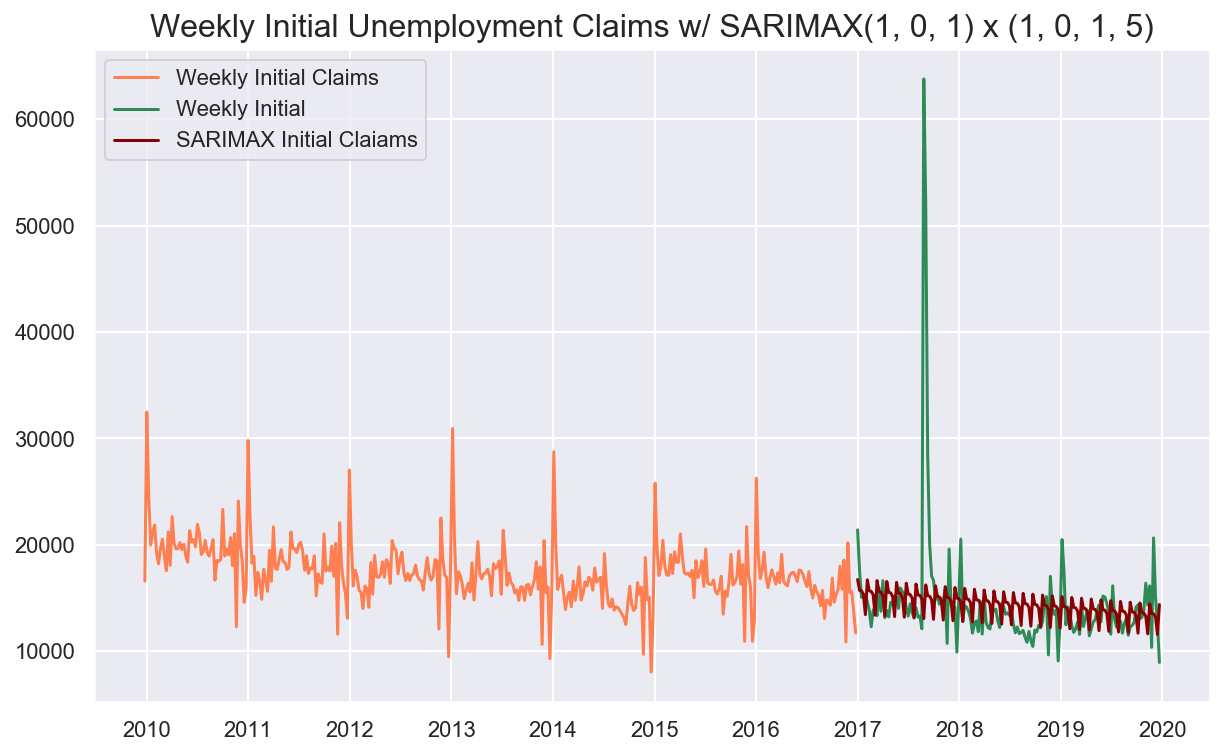

In [36]:
# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = 'Weekly Initial Unemployment Claims w/ SARIMAX(1, 0, 1) x (1, 0, 1, 5)', fontsize=16);
sns.lineplot(data=train['Initial Claims'], color="coral", label="Weekly Initial Claims")
sns.lineplot(data=test['Initial Claims'], color="seagreen", label="Weekly Initial")
sns.lineplot(x = test.index, y = preds.values, color = 'darkred', label = 'SARIMAX Initial Claiams')

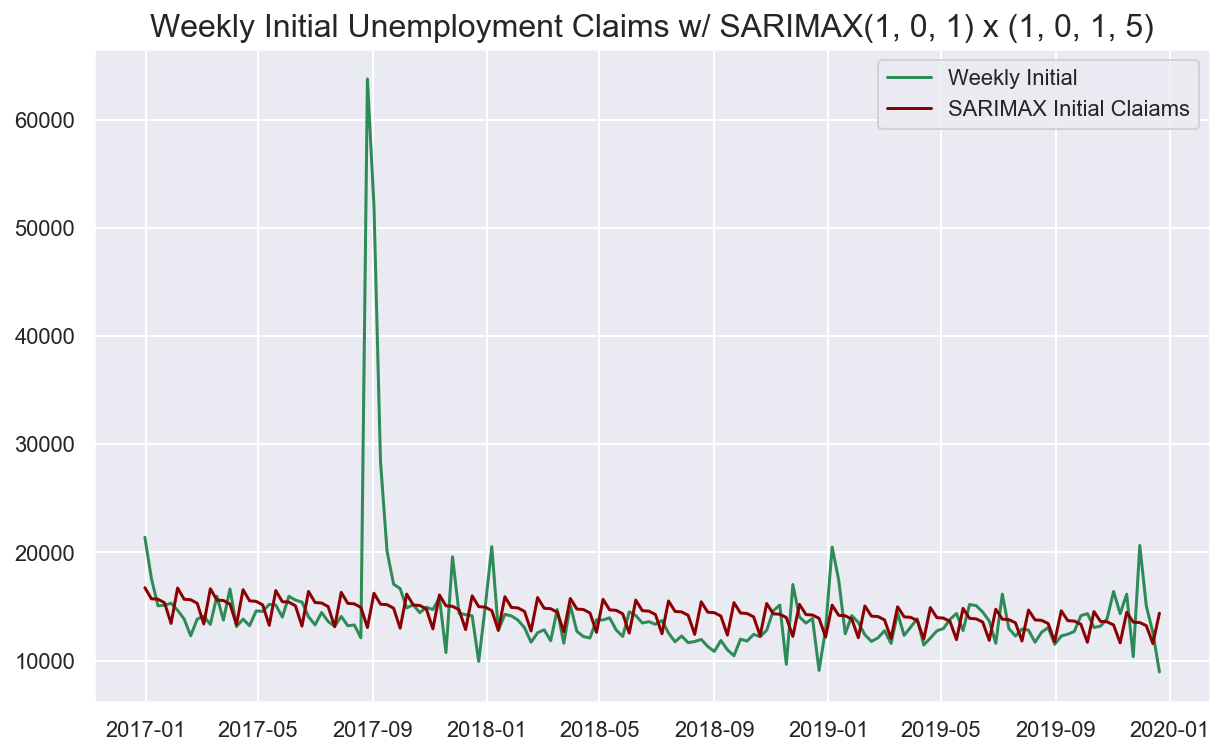

In [37]:
# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = 'Weekly Initial Unemployment Claims w/ SARIMAX(1, 0, 1) x (1, 0, 1, 5)', fontsize=16);
#sns.lineplot(data=train['Initial Claims'], color="coral", label="Weekly Initial Claims")
sns.lineplot(data=test['Initial Claims'], color="seagreen", label="Weekly Initial")
sns.lineplot(x = test.index, y = preds.values, color = 'darkred', label = 'SARIMAX Initial Claiams')

In [39]:
preds = pd.DataFrame(preds, columns= ['Predicted Initial Claims'])
preds.head()

,Predicted Initial Claims
2016-12-31,16743.153356
2017-01-07,15711.630140
2017-01-14,15675.889550
2017-01-21,15347.489463
2017-01-28,13437.930157
